# Adaptive Kalman Filter

This code implements the adaptive Kalman filter for a scalar system with an unknown measurement noise covariance matrix R.

The filter is based on the work in "Adaptive Kalman Filter for Detectable Linear Time-Invariant Systems" by Moghe, Zanetti and Akella at https://arc.aiaa.org/doi/full/10.2514/1.G004359.

Begin with some boilerplate steps:

  * Import `numpy` and `matplotlib`
  * Define the system parameters `F, H, Q, R`
  * Define the number of sample runs `N`
  * Define the number of timesteps to simulate `T`  
  * Initialize
    * State estimate `x_post`
    * State estimate error covariance `P_post`
    * Measurement noise covariance estimate `R_est`
    * Measurement error covariance `L`

In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
F, H, Q, R = 0.5, 2, 4, 10
N, T = 10, 10000
x_post0, P_post0, R_est0, L0 = 0, 100, 100, 0
k_hist = np.arange(T)+1
print_k = np.logspace(0,np.log10(T),np.log10(T)+1)

Precompute some quantities needed for the noise covariance estimation.

In [2]:
Mopi    = 1/H
A1      = 1
B1      = -F*Mopi
B2      = Mopi
kronA   = A1**2
kronB   = B1**2+B2**2
S       = np.copy(kronB)
CW      = kronA*Q

Define the noise covariance estimation function 
(the "adaptive" part) ...

In [3]:
def noise_covariance_estimation(y_new, y_old, L, k):
    Z = Mopi*(y_new-F*y_old)
    L = L*(k-1)/k + Z*Z/k
    return (L-CW)/S, L

... and the state estimation function 
(standard Kalman filter updates).

In [4]:
def state_estimation(y_new, x_post, P_post, R_est):
    x_pre  = F*x_post
    P_pre  = F*P_post*F + Q
    K      = P_pre*H/(H*P_pre*H+R_est)
    x_post = x_pre + K*(y_new-H*x_pre)
    IKH    = 1 - K*H
    P_post = IKH*P_pre*IKH + K*R_est*K
    return x_post, P_post

Define the adaptive Kalman filter iterations supporting 3 different noise estimation methods:
  * `true`  Use the true noise covariance (optimal).
  * `static`  Use an incorrect noise covariance without updating (forever suboptimal).
  * `adaptive`  Estimate and use the noise covariance (asymptotically optimal).

In [5]:
def adaptive_kalman_filter(noise_estimation_method):
    print("State estimation using %s noise covariance estimates" % noise_estimation_method)
    x_true_history, x_post_history, R_est_history  = np.zeros([N,T]), np.zeros([N,T]), np.zeros([N,T])
    R0 = R if noise_estimation_method == "true" else R_est0
    for i in range(N):
        x_post, P_post, R_est, L, x = x_post0, P_post0, R0, L0, npr.randn()
        for k in range(T):
            w, v = Q**0.5*npr.randn(), R**0.5*npr.randn()
            y_new = H*x + v
            if noise_estimation_method == "adaptive":
                if k > 0:
                    R_est_new, L = noise_covariance_estimation(y_new, y_old, L, k)
                    if R_est_new > 0:
                        R_est = R_est_new                
            elif noise_estimation_method == "static":
                R_est = R_est0
            elif noise_estimation_method == "true":
                R_est = R
            R_est_history[i,k] = R_est
            x_post, P_post = state_estimation(y_new, x_post, P_post, R_est)
            x_post_history[i,k] = x_post
            x_true_history[i,k] = x            
            x = F*x + w
            y_old = np.copy(y_new)
            if k+1 in print_k:
                print('i = %3d, k = %8d: R_true = %8.6f, R_est = %8.6f' % (i+1, k+1, R, R_est))
    print('')
    return x_true_history, x_post_history, R_est_history

Run the (adaptive) Kalman filter iterations.

In [6]:
x_true_history_true,     x_post_history_true,     R_est_history_true     = adaptive_kalman_filter("true")
x_true_history_static,   x_post_history_static,   R_est_history_static   = adaptive_kalman_filter("static")
x_true_history_adaptive, x_post_history_adaptive, R_est_history_adaptive = adaptive_kalman_filter("adaptive")

State estimation using true noise covariance estimates
i =   1, k =        1: R_true = 10.000000, R_est = 10.000000
i =   1, k =       10: R_true = 10.000000, R_est = 10.000000
i =   1, k =      100: R_true = 10.000000, R_est = 10.000000
i =   1, k =     1000: R_true = 10.000000, R_est = 10.000000
i =   1, k =    10000: R_true = 10.000000, R_est = 10.000000
i =   2, k =        1: R_true = 10.000000, R_est = 10.000000
i =   2, k =       10: R_true = 10.000000, R_est = 10.000000
i =   2, k =      100: R_true = 10.000000, R_est = 10.000000
i =   2, k =     1000: R_true = 10.000000, R_est = 10.000000
i =   2, k =    10000: R_true = 10.000000, R_est = 10.000000
i =   3, k =        1: R_true = 10.000000, R_est = 10.000000
i =   3, k =       10: R_true = 10.000000, R_est = 10.000000
i =   3, k =      100: R_true = 10.000000, R_est = 10.000000
i =   3, k =     1000: R_true = 10.000000, R_est = 10.000000
i =   3, k =    10000: R_true = 10.000000, R_est = 10.000000
i =   4, k =        1: R_true 

i =   8, k =    10000: R_true = 10.000000, R_est = 10.850193
i =   9, k =        1: R_true = 10.000000, R_est = 100.000000
i =   9, k =       10: R_true = 10.000000, R_est = 4.079533
i =   9, k =      100: R_true = 10.000000, R_est = 8.494333
i =   9, k =     1000: R_true = 10.000000, R_est = 11.932277
i =   9, k =    10000: R_true = 10.000000, R_est = 10.227440
i =  10, k =        1: R_true = 10.000000, R_est = 100.000000
i =  10, k =       10: R_true = 10.000000, R_est = 8.931906
i =  10, k =      100: R_true = 10.000000, R_est = 9.360691
i =  10, k =     1000: R_true = 10.000000, R_est = 11.261644
i =  10, k =    10000: R_true = 10.000000, R_est = 10.068434



Plot the results of the estimation error of R vs time using the adaptive Kalman filter.
  * log-log plot shows convergence to the true value
  * Convergence follows the slow geometric rate of $\mathcal{O}\left(\frac{1}{\sqrt{k}}\right)$ typical of least-squares estimators

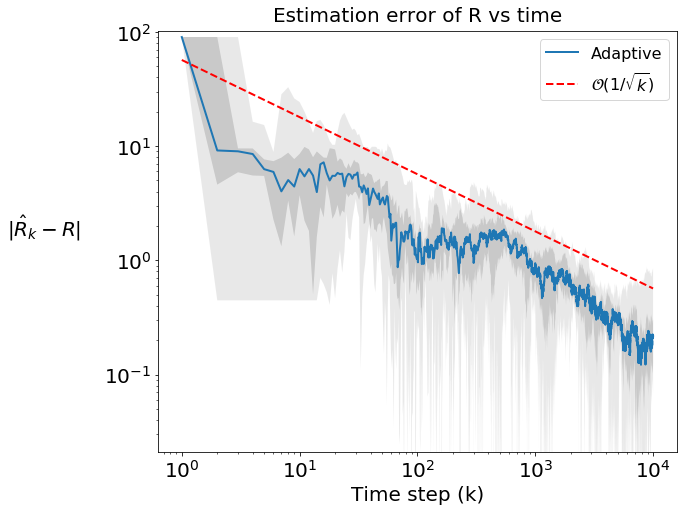

In [7]:
fig,ax = plt.subplots(figsize=(12, 8))
R_err = {}
for perc in [0,25,50,75,100]:
    R_err[perc] = np.percentile(np.abs(R_est_history_adaptive-R),perc,axis=0)
guideline = np.power(k_hist,-0.5)
guideline = np.max(R_err[75][10:]/guideline[10:])*guideline
plt.fill_between(k_hist, R_err[25], R_err[75], facecolor='grey', alpha=0.5)
plt.fill_between(k_hist, R_err[0], R_err[100], facecolor='lightgrey', alpha=0.5)
plt.loglog(k_hist, R_err[50], linewidth=2)
plt.loglog(k_hist, guideline, 'r--', linewidth=2)
plt.ylim([R_err[25].min(),R_err[100].max()*1.12])
plt.xlabel("Time step (k)")
plt.ylabel(r"$|\hat{R}_k-R|$",rotation=0,labelpad=60)
plt.title("Estimation error of R vs time",pad=10)
plt.legend(["Adaptive",r"$\mathcal{O}(1/\sqrt{k})$"],fontsize=16)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
fig.subplots_adjust(left = 0.3,bottom = 0.15)

Plot the results of the mean-square state estimation error vs time.
  * Adaptive state estimates converge to the optimal ones using true `R`
  * Static state estimates using incorrect `R` are suboptimal and never improve

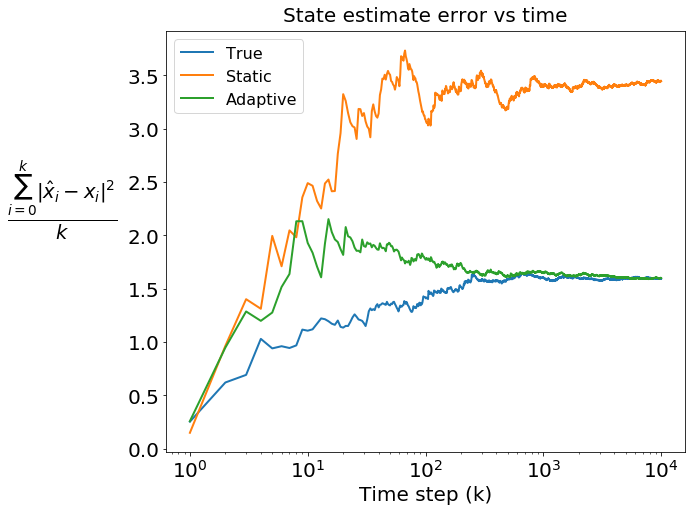

In [8]:
fig,ax = plt.subplots(figsize=(12, 8))
mse_true = np.cumsum(np.square(x_post_history_true-x_true_history_true),axis=1)/k_hist
mse_static = np.cumsum(np.square(x_post_history_static-x_true_history_static),axis=1)/k_hist
mse_adaptive = np.cumsum(np.square(x_post_history_adaptive-x_true_history_adaptive),axis=1)/k_hist
plt.semilogx(k_hist, np.median(mse_true,axis=0), linewidth=2)
plt.semilogx(k_hist, np.median(mse_static,axis=0), linewidth=2)
plt.semilogx(k_hist, np.median(mse_adaptive,axis=0), linewidth=2)
plt.xlabel("Time step (k)")
plt.ylabel(r"$\frac{\sum_{i=0}^k \| \hat{x}_i-x_i \|^2}{k}$",rotation=0,labelpad=65,fontsize=28)
plt.title("State estimate error vs time",pad=10)
plt.legend(["True","Static","Adaptive"],fontsize=16)
for item in ([ax.title, ax.xaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
fig.subplots_adjust(left = 0.3,bottom = 0.15)